In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Dropout, Input
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

2025-01-14 07:53:47.041717: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 07:53:47.081942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-14 07:53:47.081978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-14 07:53:47.083281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 07:53:47.089894: I tensorflow/core/platform/cpu_feature_guar

In [2]:
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
batch_size = 8
lr = 1e-4
epochs = 100
height = 256
width = 256 


In [4]:
# Define base directories
base_dir = os.getcwd()  # Current working directory (optional, can be modified)
dataset_path = os.path.join(base_dir, "dataset")
files_dir = os.path.join(base_dir, "files")

# Create the files directory if it doesn't exist
os.makedirs(files_dir, exist_ok=True)

# Define file paths for model and logs
model_file = os.path.join(files_dir, "unet.h5")
log_file = os.path.join(files_dir, "log.csv")

print(f"Dataset Path: {dataset_path}")
print(f"Files Directory: {files_dir}")
print(f"Model File: {model_file}")
print(f"Log File: {log_file}")


Dataset Path: /home/y2b/dataset/dataset
Files Directory: /home/y2b/dataset/files
Model File: /home/y2b/dataset/files/unet.h5
Log File: /home/y2b/dataset/files/log.csv


In [5]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
create_dir(files_dir)

In [7]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [8]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2)) (x)
    return x, p

In [9]:
from tensorflow.keras.layers import Concatenate

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])  # Correct usage of Concatenate
    x = conv_block(x, num_filters)
    return x


In [10]:
def build_unet(input_shape):
    """
    Builds a U-Net model for image segmentation.

    Parameters:
        input_shape (tuple): Shape of the input image (height, width, channels).

    Returns:
        model (tf.keras.Model): The U-Net model.
    """
    inputs = Input(shape=input_shape)

    # Encoder: Downsampling layers
    encoder_filters = [64, 128, 256, 512]
    skips = []
    x = inputs
    for num_filters in encoder_filters:
        skip, x = encoder_block(x, num_filters)
        skips.append(skip)

    # Bottleneck: Bottom layer of the U-Net
    bottleneck_filters = 1024
    x = conv_block(x, bottleneck_filters)

    # Decoder: Upsampling layers with skip connections
    decoder_filters = [512, 256, 128, 64]
    for num_filters, skip in zip(decoder_filters, reversed(skips)):
        x = decoder_block(x, skip, num_filters)

    # Output layer: 1-channel with sigmoid activation for binary segmentation
    output_channels = 1
    outputs = Conv2D(output_channels, kernel_size=1, padding="same", activation="sigmoid")(x)

    # Create and return the model
    return Model(inputs=inputs, outputs=outputs, name="UNET")


In [12]:
import os
from glob import glob

# Correct dataset_path
dataset_path = base_dir  # Gebruik direct de juiste map

# Controleer of de benodigde mappen bestaan
required_dirs = ["train_images", "train_masks", "val_images", "val_masks"]
for folder in required_dirs:
    folder_path = os.path.join(dataset_path, folder)
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Directory not found: {folder_path}")

# Functie om data te laden
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "train_images", "*.*")))
    train_y = sorted(glob(os.path.join(path, "train_masks", "*.*")))

    valid_x = sorted(glob(os.path.join(path, "val_images", "*.*")))
    valid_y = sorted(glob(os.path.join(path, "val_masks", "*.*")))

    if len(train_x) == 0 or len(train_y) == 0:
        raise ValueError("Train dataset is empty. Check paths and file contents.")
    if len(valid_x) == 0 or len(valid_y) == 0:
        raise ValueError("Validation dataset is empty. Check paths and file contents.")

    return (train_x, train_y), (valid_x, valid_y)

# Load and print dataset info
train_data, valid_data = load_data(dataset_path)
train_x, train_y = train_data
valid_x, valid_y = valid_data

print(f"Training Set: {len(train_x)} images, {len(train_y)} masks")
print(f"Validation Set: {len(valid_x)} images, {len(valid_y)} masks")


Training Set: 1060 images, 1060 masks
Validation Set: 205 images, 205 masks


In [13]:
def read_image(path):
    path = path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    return x

In [14]:
def read_mask(path):
    path = path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [15]:
def tf_parse(x, y):
    def _parse(x,y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])

    return x, y

In [16]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

__Training__

In [17]:
# Load the data
train_data, valid_data = load_data(dataset_path)
train_x, train_y = train_data
valid_x, valid_y = valid_data

# Print dataset sizes with descriptive output
print(f"Training Set: {len(train_x)} images, {len(train_y)} masks")
print(f"Validation Set: {len(valid_x)} images, {len(valid_y)} masks")

Training Set: 1060 images, 1060 masks
Validation Set: 205 images, 205 masks


In [18]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

2025-01-14 07:56:36.362958: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-14 07:56:36.363223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43086 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:e1:00.0, compute capability: 8.9


In [19]:
for x, y in train_dataset:
    print(x.shape, y.shape)

(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 3) (8, 256, 256, 1)
(8, 256, 256, 

In [20]:
input_shape = (height, width, 3 )
model = build_unet(input_shape)

In [21]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

In [22]:
import tensorflow.keras.backend as K
import tensorflow as tf

def f1_score(y_true, y_pred):
    """
    Computes the F1 score for binary classification tasks.

    Parameters:
        y_true (Tensor): Ground truth labels.
        y_pred (Tensor): Predicted labels.

    Returns:
        Tensor: Batch-wise average F1 score.
    """
    # Ensure the correct data type
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    
    # Round predictions to 0 or 1
    y_pred = K.round(y_pred)
    
    # True positives, precision, and recall
    tp = K.sum(K.cast(y_true * y_pred, dtype='float32'), axis=(1, 2))
    precision = tp / (K.sum(K.cast(y_pred, dtype='float32'), axis=(1, 2)) + K.epsilon())
    recall = tp / (K.sum(K.cast(y_true, dtype='float32'), axis=(1, 2)) + K.epsilon())
    
    # Compute the F1 score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    # Return the mean F1 score across the batch
    return K.mean(f1)

# Define the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Compile the model with the specified optimizer and metrics
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=["accuracy", f1_score]  # Include both accuracy and the custom F1 score
)


In [23]:
model_file = os.path.join(files_dir, "unet.h5")
callbacks = [
    ModelCheckpoint(
        filepath=model_file, 
        save_best_only=True, 
        save_weights_only=False,  # Save the entire model, not just weights
        verbose=1
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
]


In [24]:
model.fit(
    train_dataset,
    validation_data =valid_dataset,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100


2025-01-14 07:56:51.118943: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-01-14 07:56:54.781647: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc9ce842ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-14 07:56:54.781686: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-01-14 07:56:54.786765: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736841414.893796    2638 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


133/133 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.9094 - f1_score: 0.4811
Epoch 1: val_loss improved from inf to 0.43378, saving model to /home/y2b/dataset/files/unet.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - 37s 134ms/step - loss: 0.3429 - accuracy: 0.9094 - f1_score: 0.4811 - val_loss: 0.4338 - val_accuracy: 0.9575 - val_f1_score: 5.2043e-05 - lr: 1.0000e-04
Epoch 2/100
132/133 [============================>.] - ETA: 0s - loss: 0.1736 - accuracy: 0.9666 - f1_score: 0.6420
Epoch 2: val_loss improved from 0.43378 to 0.21454, saving model to /home/y2b/dataset/files/unet.h5
133/133 [==============================] - 12s 92ms/step - loss: 0.1735 - accuracy: 0.9666 - f1_score: 0.6426 - val_loss: 0.2145 - val_accuracy: 0.9576 - val_f1_score: 2.3533e-04 - lr: 1.0000e-04
Epoch 3/100
132/133 [============================>.] - ETA: 0s - loss: 0.1506 - accuracy: 0.9687 - f1_score: 0.6725
Epoch 3: val_loss did not improve from 0.21454
133/133 [==============================] - 12s 89ms/step - loss: 0.1507 - accuracy: 0.9687 - f1_score: 0.6729 - val_loss: 0.2665 - val_accuracy: 0.9564 - val_f1_score: 0.0134 - lr: 1.0000e-04
Epoch 4/100
132/133 [===============

In [26]:
# Build and compile the model
input_shape = (height, width, 3)
model = build_unet(input_shape)

# Compile the model with the optimizer, loss, and metrics (including F1 score)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=["accuracy", f1_score]  
)

# Train the model
model.fit(
    train_dataset, 
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks
)

# Save the model in .h5 format
model.save(model_file)


Epoch 1/100
132/133 [============================>.] - ETA: 0s - loss: 0.3879 - accuracy: 0.8864 - f1_score: 0.4853
Epoch 1: val_loss did not improve from 0.04665
133/133 [==============================] - 22s 89ms/step - loss: 0.3873 - accuracy: 0.8867 - f1_score: 0.4870 - val_loss: 0.4082 - val_accuracy: 0.9576 - val_f1_score: 0.0019 - lr: 1.0000e-04
Epoch 2/100
132/133 [============================>.] - ETA: 0s - loss: 0.1910 - accuracy: 0.9689 - f1_score: 0.6777
Epoch 2: val_loss did not improve from 0.04665
133/133 [==============================] - 11s 86ms/step - loss: 0.1909 - accuracy: 0.9689 - f1_score: 0.6783 - val_loss: 0.2192 - val_accuracy: 0.9579 - val_f1_score: 0.0110 - lr: 1.0000e-04
Epoch 3/100
132/133 [============================>.] - ETA: 0s - loss: 0.1549 - accuracy: 0.9720 - f1_score: 0.7186
Epoch 3: val_loss did not improve from 0.04665
133/133 [==============================] - 11s 85ms/step - loss: 0.1549 - accuracy: 0.9720 - f1_score: 0.7190 - val_loss: 0.172

INFO: generated new fontManager


       loss  accuracy  f1_score  val_loss  val_accuracy  val_f1_score      lr
0  0.387273  0.886726  0.486972  0.408246      0.957570      0.001899  0.0001
1  0.190863  0.968902  0.678254  0.219241      0.957901      0.011001  0.0001
2  0.154859  0.972008  0.718965  0.172245      0.960527      0.253130  0.0001
3  0.135968  0.973439  0.740042  0.145055      0.968363      0.566984  0.0001
4  0.123673  0.974336  0.749655  0.091105      0.979895      0.656835  0.0001


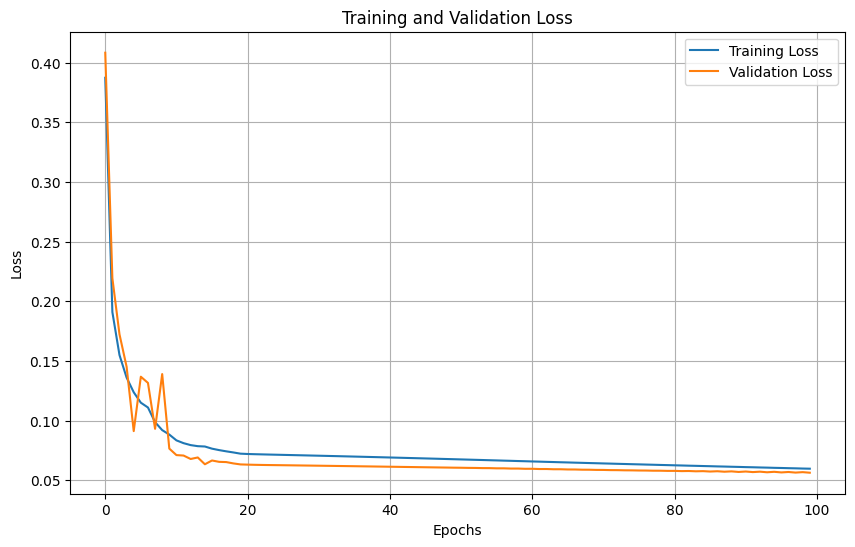

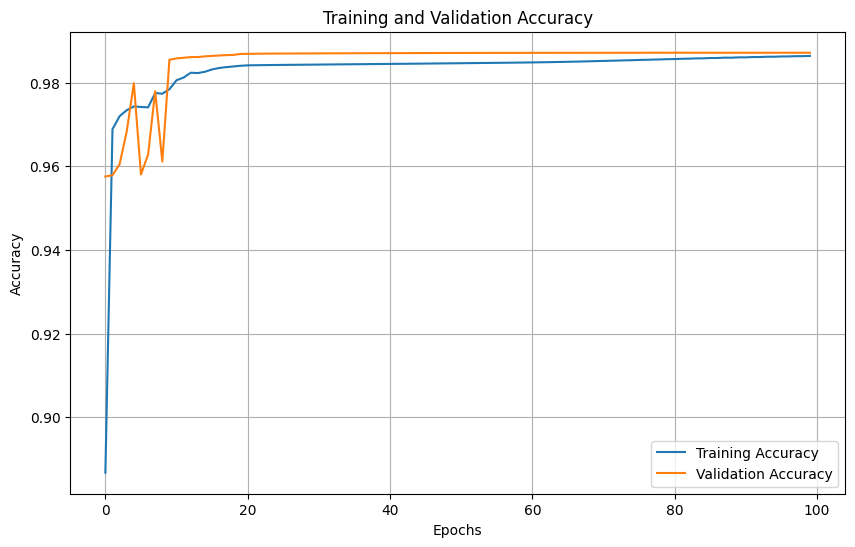

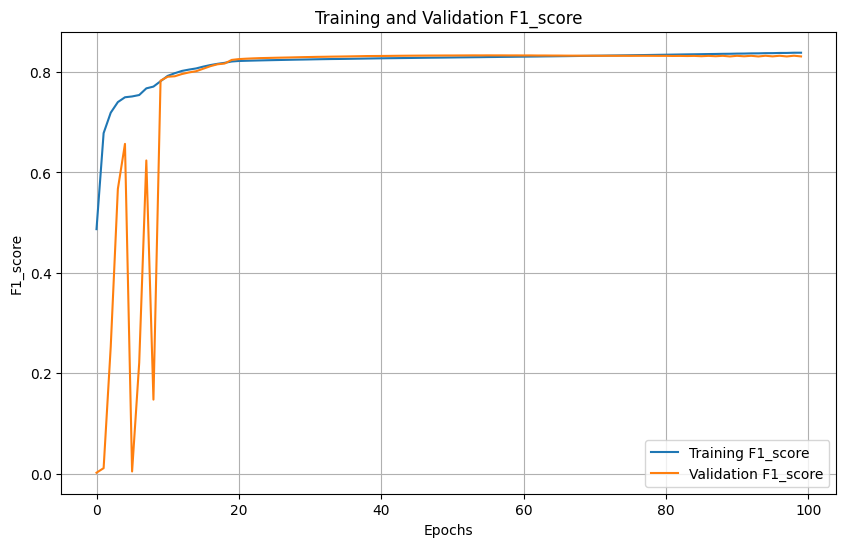

Best validation loss: 0.056237123906612396 at epoch 100

Final Training Metrics:
Loss: 0.0596, Accuracy: 0.9864, F1 Score: 0.8384

Final Validation Metrics:
Loss: 0.0562, Accuracy: 0.9872, F1 Score: 0.8310


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Retrieve history from the model's training process
history = model.history.history

# Convert the history to a DataFrame for easy analysis
history_df = pd.DataFrame(history)

# Display the first few rows to inspect
print(history_df.head())

# Plotting training and validation metrics
def plot_metrics(history_df):
    metrics = ["loss", "accuracy", "f1_score"]
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        plt.plot(history_df[metric], label=f"Training {metric.capitalize()}")
        plt.plot(history_df[f"val_{metric}"], label=f"Validation {metric.capitalize()}")
        plt.title(f"Training and Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid()
        plt.show()

# Call the plotting function
plot_metrics(history_df)

# Print the best validation loss and its corresponding epoch
best_val_loss_epoch = history_df['val_loss'].idxmin() + 1
print(f"Best validation loss: {history_df['val_loss'].min()} at epoch {best_val_loss_epoch}")

# Print final training metrics
final_epoch = len(history_df)
print("\nFinal Training Metrics:")
print(f"Loss: {history_df['loss'].iloc[-1]:.4f}, Accuracy: {history_df['accuracy'].iloc[-1]:.4f}, F1 Score: {history_df['f1_score'].iloc[-1]:.4f}")

# Print final validation metrics
print("\nFinal Validation Metrics:")
print(f"Loss: {history_df['val_loss'].iloc[-1]:.4f}, Accuracy: {history_df['val_accuracy'].iloc[-1]:.4f}, F1 Score: {history_df['val_f1_score'].iloc[-1]:.4f}")
